In [2]:
'''
    Modified version of https://github.com/EigenPro/EigenPro-tensorflow
    in particular run_expr.py
'''

from __future__ import print_function

import argparse
import collections
import keras
import numpy as np
import time
import warnings

from distutils.version import StrictVersion
from keras.layers import Dense, Input
from keras.models import Model
from keras import backend as K

from eigenpro import kernels
from eigenpro import mnist
from eigenpro import ciphar
from eigenpro import synthetic
from eigenpro import utils
from eigenpro import training

from eigenpro.backend_extra import hasGPU
from eigenpro.layers import KernelEmbedding, RFF
from eigenpro.optimizers import PSGD, SGD

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.8'), \
       "Requires Keras (>=2.0.8)."

if StrictVersion(keras.__version__) > StrictVersion('2.0.8'):
    warnings.warn('\n\nEigenPro-tensorflow has been tested with Keras 2.0.8. '
                   'If the\ncurrent version (%s) fails, ' 
                   'switch to 2.0.8 by command,\n\n'
                   '\tpip install Keras==2.0.8\n\n' %(keras.__version__), Warning)

assert keras.backend.backend() == u'tensorflow', \
       "Requires Tensorflow (>=1.2.1)."
# assert hasGPU(), "Requires GPU."

Using TensorFlow backend.
/home/johannes/seminar/kernel-overfitting/eigenpro/training.py:44: Warning: 

EigenPro-tensorflow has been tested with Keras 2.0.8. If the
current version (2.2.4) fails, switch to 2.0.8 by command,

	pip install Keras==2.0.8


  '\tpip install Keras==2.0.8\n\n' %(keras.__version__), Warning)
/home/johannes/anaconda3/envs/semi/lib/python3.7/site-packages/ipykernel_launcher.py:38: Warning: 

EigenPro-tensorflow has been tested with Keras 2.0.8. If the
current version (2.2.4) fails, switch to 2.0.8 by command,

	pip install Keras==2.0.8




In [3]:
# Set the hyper-parameters.
bs = 256            # size of the mini-batch
M = 4800            # (EigenPro) subsample size
k = 160             # (EigenPro) top-k eigensystem

dataset = 'MNIST'

In [4]:
if dataset is 'MNIST':
    num_classes = 10  
    (x_train, y_train), (x_test, y_test) = mnist.load()
elif dataset is 'CIPHAR':
    num_classes = 10  
    (x_train, y_train), (x_test, y_test) = ciphar.load()
elif dataset is 'Synthetic1':
    num_classes = 2
    (x_train, y_train), (x_test, y_test) = synthetic.load(1)
elif dataset is 'Synthetic2':
    num_classes = 2
    (x_train, y_train), (x_test, y_test) = synthetic.load(2)

Load MNIST dataset.
60000 train samples
10000 test samples


In [5]:
### NOGPU
size = 1000
x_train = x_train[0:size]
y_train = y_train[0:size]
M = 400
### NOGPU End

n, D = x_train.shape    # (n_sample, n_feature)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
trainers = collections.OrderedDict()
Trainer = collections.namedtuple('Trainer', ['model', 'x_train', 'x_test', 'tr_scores', 'te_scores'])

input_shape = (D+1,) # n_feature, (sample) index
ix = Input(shape=input_shape, dtype='float32', name='indexed-feat')
x, index = utils.separate_index(ix)	# features, sample_id

## Gauss

# Calculate step size and (Primal) EigenPro preconditioner.
s = 5   # kernel bandwidth
kernel = lambda x,y: kernels.Gaussian(x, y, s)
kfeat = KernelEmbedding(kernel, x_train, input_shape=(D,))(x)
kf, scale, s0 = utils.asm_eigenpro_f(
    x_train, kernel, M, k, 1, in_rkhs=True)
eta = np.float32(1.5 / s0) # 1.5 / s0
eta = eta * num_classes # correction due to mse loss

# Assemble kernel EigenPro trainer.
y = Dense(num_classes, input_shape=(n,),
          activation='linear',
          kernel_initializer='zeros',
          use_bias=False)(kfeat)
model = Model(ix, y)
model.compile(loss='mse',
              optimizer=PSGD(pred_t=y,
                             index_t=index,
                             eta=scale*eta,
                             eigenpro_f=lambda g: kf(g, kfeat)),
              metrics=['accuracy'])
trainers['Gauss'] = Trainer(model=model,
                              x_train = utils.add_index(x_train),
                              x_test=utils.add_index(x_test),
                              tr_scores={},
                              te_scores={})


## Laplace

# Calculate step size and (Primal) EigenPro preconditioner.
s = np.float32(10)
kernel = lambda x,y: kernels.Laplace(x, y, s)
kfeat = KernelEmbedding(kernel, x_train, input_shape=(D,))(x)
kf, scale, s0 = utils.asm_eigenpro_f(
    x_train, kernel, M, k, 1, in_rkhs=True)
eta = np.float32(1.5 / s0) # 1.5 / s0
eta = eta * num_classes # correction due to mse loss

# Assemble kernel EigenPro trainer.
y = Dense(num_classes, input_shape=(n,),
          activation='linear',
          kernel_initializer='zeros',
          use_bias=False)(kfeat)
model = Model(ix, y)
model.compile(loss='mse',
              optimizer=PSGD(pred_t=y,
                             index_t=index,
                             eta=scale*eta,
                             eigenpro_f=lambda g: kf(g, kfeat)),
              metrics=['accuracy'])
trainers['Laplace'] = Trainer(model=model,
                              x_train = utils.add_index(x_train),
                              x_test=utils.add_index(x_test),
                              tr_scores={},
                              te_scores={})



# Start training.
for name, trainer in trainers.items():   
    print("")
    initial_epoch=0
    np.random.seed(1) # Keras uses numpy random number generator
    train_ts = 0 # training time in seconds
    for epoch in [1, 2, 5, 10, 20]:
        start = time.time()
        trainer.model.fit(
            trainer.x_train, y_train,
            batch_size=bs, epochs=epoch, verbose=0,
            validation_data=(trainer.x_test, y_test),
            initial_epoch=initial_epoch)
        train_ts += time.time() - start
        tr_score = trainer.model.evaluate(trainer.x_train, y_train, verbose=0)
        te_score = trainer.model.evaluate(trainer.x_test, y_test, verbose=0)
        trainer.tr_scores[epoch] = tr_score
        trainer.te_scores[epoch] = te_score
        print("%s\t\ttrain error: %.2f%%\ttest error: %.2f%% (%d epochs, %.2f seconds)" %
              (name, (1 - tr_score[1]) * 100, (1 - te_score[1]) * 100, epoch, train_ts))
        initial_epoch = epoch

Instructions for updating:
Colocations handled automatically by placer.
SVD time: 0.30, Eigenvalue ratio: 156.21
SVD time: 0.30, Eigenvalue ratio: 499.62

Instructions for updating:
Use tf.cast instead.
Gauss		train error: 1.10%	test error: 9.89% (1 epochs, 0.92 seconds)
Gauss		train error: 0.00%	test error: 8.85% (2 epochs, 1.47 seconds)
Gauss		train error: 0.00%	test error: 7.91% (5 epochs, 2.93 seconds)
Gauss		train error: 0.00%	test error: 7.71% (10 epochs, 4.93 seconds)
Gauss		train error: 0.00%	test error: 7.72% (20 epochs, 8.45 seconds)

Laplace		train error: 2.00%	test error: 14.17% (1 epochs, 0.91 seconds)
Laplace		train error: 0.10%	test error: 11.51% (2 epochs, 1.35 seconds)
Laplace		train error: 0.00%	test error: 9.97% (5 epochs, 3.53 seconds)
Laplace		train error: 0.00%	test error: 9.23% (10 epochs, 5.96 seconds)
Laplace		train error: 0.00%	test error: 9.00% (20 epochs, 9.96 seconds)


In [7]:
trainers_dict = {}

for name, trainer in  trainers.items():  
    
    trainers_dict[name] = {'tr_scores': trainer.tr_scores, 'te_scores': trainer.te_scores}    
    
    if name is 'Gauss':
        s = 5
        kernel = lambda x,y: training.Gaussian(x, y, s)
    else:
        s = 10
        kernel = lambda x,y: training.Laplace(x, y, s) 
        
    K = kernel(x_train, x_train)
    alpha_lin = np.linalg.solve(K, y_train)    
    pred_train = K.T.dot(alpha_lin)    
    
    y = y_train
    mse = (np.square(pred_train - y)).mean(axis=None)
    miss = np.count_nonzero(np.argmax(pred_train, axis=1) - np.argmax(y, axis=1)) / y.shape[0]
    trainers_dict[name]['lin_train_mse'] = mse
    trainers_dict[name]['lin_train_ce'] = miss
    
    
    testK = kernel(x_train, x_test)
    pred_test = testK.T.dot(alpha_lin)
    
    y = y_test
    mse = (np.square(pred_test - y)).mean(axis=None)
    miss = np.count_nonzero(np.argmax(pred_test, axis=1) - np.argmax(y, axis=1)) / y.shape[0]  
    trainers_dict[name]['lin_test_mse'] = mse
    trainers_dict[name]['lin_test_ce'] = miss

trainers_dict

with open('output/figure1' + dataset + '-' + time.strftime("%Y%m%d-%H%M%S") + '.txt', 'w') as f:
    print(trainers_dict, file=f)

In [8]:
# trainers_dict = eval(open('figure1MNIST.txt', 'r').read())
trainers_dict

{'Gauss': {'tr_scores': {1: [0.01216489953547716, 0.989],
   2: [0.005671584781259298, 1.0],
   5: [0.0013807735424488782, 1.0],
   10: [0.00028793091443367303, 1.0],
   20: [4.1342297190567476e-05, 1.0]},
  'te_scores': {1: [0.027332050225138665, 0.9011],
   2: [0.02348214246034622, 0.9115],
   5: [0.021435677435994147, 0.9209],
   10: [0.02081791154369712, 0.9229],
   20: [0.020627705762535333, 0.9228]},
  'lin_train_mse': 1.3588872e-13,
  'lin_train_ce': 0.0,
  'lin_test_mse': 0.020540396,
  'lin_test_ce': 0.0784},
 'Laplace': {'tr_scores': {1: [0.02723619595170021, 0.98],
   2: [0.013677788898348808, 0.999],
   5: [0.0034702620562165973, 1.0],
   10: [0.0005864836974069476, 1.0],
   20: [3.020493226358667e-05, 1.0]},
  'te_scores': {1: [0.04256515776515007, 0.8583],
   2: [0.03348366622626781, 0.8849],
   5: [0.02742201258391142, 0.9003],
   10: [0.02544576589167118, 0.9077],
   20: [0.024831237389147283, 0.91]},
  'lin_train_mse': 5.3828735e-13,
  'lin_train_ce': 0.0,
  'lin_test_

MNIST


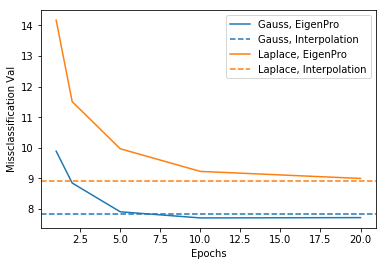

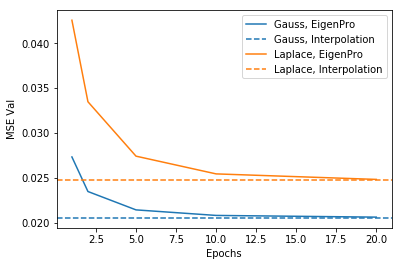

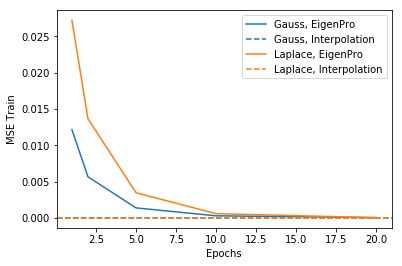

In [10]:
import matplotlib.pyplot as plt
ax = plt.gca()

print(dataset)

for name, trainer in trainers_dict.items():  
    
    dic = trainer['te_scores']
    
    epoch = [x for x in dic.keys()]
    mse   = [x[0] for x in dic.values()]
    miss  = [(1 - x[1]) * 100 for x in dic.values()]

    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(epoch, miss, label=name + ', EigenPro', color=color)      
    plt.axhline(y=trainer['lin_test_ce'] * 100, label=name + ', Interpolation', linestyle='--', color=color)

plt.xlabel('Epochs')
plt.ylabel('Missclassification Val')
plt.legend(loc='upper right')
plt.show()

ax.set_prop_cycle(None)

for name, trainer in trainers_dict.items():  
    
    dic = trainer['te_scores']
    
    epoch = [x for x in dic.keys()]
    mse   = [x[0] for x in dic.values()]
    miss  = [x[1] for x in dic.values()]

    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(epoch, mse, label=name + ', EigenPro', color=color) 
    plt.axhline(y=trainer['lin_test_mse'], label=name + ', Interpolation', linestyle='--', color=color)
    
plt.xlabel('Epochs')
plt.ylabel('MSE Val')
plt.legend(loc='upper right')
plt.show()

ax.set_prop_cycle(None)

for name, trainer in trainers_dict.items():  
    
    dic = trainer['tr_scores']
    
    epoch = [x for x in dic.keys()]
    mse   = [x[0] for x in dic.values()]
    miss  = [x[1] for x in dic.values()]

    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(epoch, mse, label=name + ', EigenPro', color=color) 
    plt.axhline(y=trainer['lin_train_mse'], label=name + ', Interpolation', linestyle='--', color=color)
    
plt.xlabel('Epochs')
plt.ylabel('MSE Train')
plt.legend(loc='upper right')
plt.show()


In [9]:
# del trainers
utils.reset()